In [199]:
import numpy as np
import pandas as pd
import cufflinks as cf
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
import plotly.express as px
from datetime import datetime,date

%matplotlib inline
init_notebook_mode(connected=True)
cf.set_config_file(sharing='private',theme='pearl',offline=True)
#print("Cufflinks Version : {}".format(cf.__version__))

df = pd.read_csv('./data/btc-usd-max.csv',index_col=0,parse_dates=True )
df = df.resample('D').first()
df.drop(["market_cap", "total_volume"], axis=1, inplace=True)
df['price'].fillna(method='ffill', inplace=True)
# to get the log price
# df['price'] = np.log(df['price'])
df2 = pd.read_csv('./data/eth-usd-max.csv',index_col=0,parse_dates=True )
df2.drop(["market_cap", "total_volume"], axis=1, inplace=True)
df2 = df2.resample('D').first()
df2['price'].fillna(method='ffill', inplace=True)
# to get the log price
# df['price'] = np.log(df['price'])

In [200]:
def first_day(entry):
    """
    Returns the first instance of the period, regardless of sampling rate.
    """
    if len(entry):  # handles the case of missing data
        return entry[0]

In [201]:
# here i will use monthly data
df2= df2.resample(rule='MS').apply(first_day)

In [202]:
from statsmodels.tsa.seasonal import seasonal_decompose

<AxesSubplot:xlabel='snapped_at'>

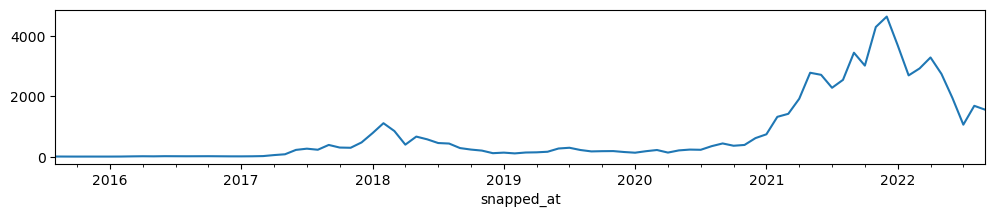

In [203]:
results = seasonal_decompose(df2['price'])
results.observed.plot(figsize=(12,2))

<AxesSubplot:xlabel='snapped_at'>

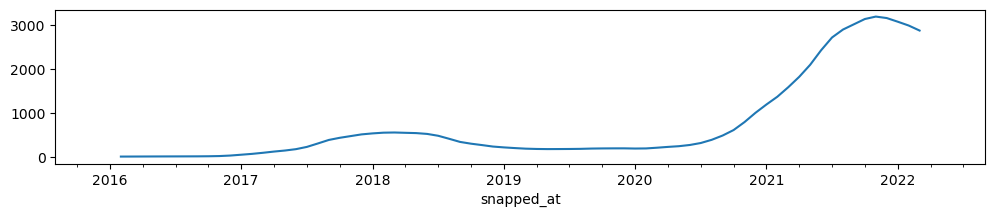

In [204]:
results.trend.plot(figsize=(12,2))

<AxesSubplot:xlabel='snapped_at'>

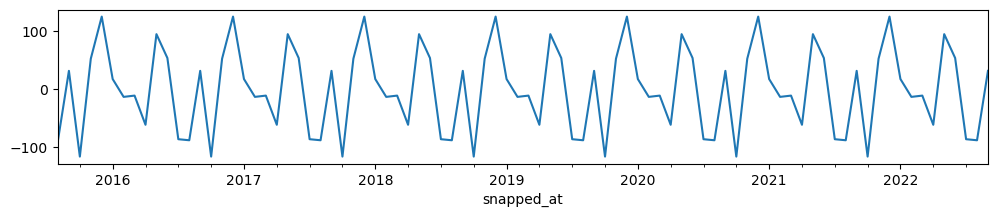

In [205]:
results.seasonal.plot(figsize=(12,2))

In [206]:
len(df2)

86

In [207]:
train = df2

In [208]:
from sklearn.preprocessing import MinMaxScaler

In [209]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [210]:
# we do this just on the training data as in real life we have no idea of the actual datra to fit for the test set
scaler.fit(train) # finds the max value in the training set

MinMaxScaler()

In [211]:
# transform the training and test data via the scaler object above. MinMaxscaler doesnt simply divide 
# by athe max or min value... it uses more complex method
scaled_train = scaler.transform(train)

In [212]:
# now everything is scaled we need to createa timeseries generator to feed the neural network
from keras.preprocessing.sequence import TimeseriesGenerator

In [213]:
# Redefine to get 48 months back and then predict the next month out
n_input = 46
n_features = 1 # for time series it is 1 as we have one output the prediction (one column of data)
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [214]:
# Create the model , train it and test it
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [215]:
# define model
model = Sequential()
# 100 is the number of neurons. we play around to find a good number and you play around
model.add(LSTM(1100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [216]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1100)              4848800   
                                                                 
 dense_6 (Dense)             (None, 1)                 1101      
                                                                 
Total params: 4,849,901
Trainable params: 4,849,901
Non-trainable params: 0
_________________________________________________________________


In [217]:
# 1 epoch is a single run through all our data
model.fit(generator,epochs = 5, batch_size =1)

Epoch 1/5
2/2 [==============================] - 2s 463ms/step - loss: 0.0909
Epoch 2/5
2/2 [==============================] - 1s 451ms/step - loss: 0.0819
Epoch 3/5
2/2 [==============================] - 1s 464ms/step - loss: 0.0035
Epoch 4/5
2/2 [==============================] - 1s 454ms/step - loss: 0.0269
Epoch 5/5
2/2 [==============================] - 1s 465ms/step - loss: 0.0414


In [218]:
model.history.history.keys()

dict_keys(['loss'])

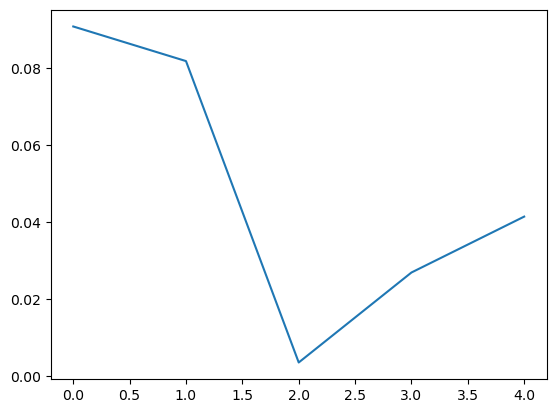

In [219]:
import matplotlib.pyplot as plt
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [220]:
# our model takes the last 12 history steps and predicts the next one 
first_eval_batch = scaled_train[-46:]

In [221]:
# in order to actually forecast into the future
test_predictions = [] # holding the predictions as we go along

# Last n_input points from the training set
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
# we use the predicted points to predict further and further into the future 
# so RNN cannot work very well far into the future
# in order to predict into the future we can change the range for example len(test)+6 to forecast another 6 months
# or we can use the actual df2 to train and freely forecast into the future!
for i in range(48):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 114ms/step


In [222]:
# Inverse Transformations and Compare
true_predictions = scaler.inverse_transform(test_predictions)

In [223]:
true_predictions

array([[583.4426676 ],
       [510.46703475],
       [446.00221407],
       [389.85012945],
       [341.37399425],
       [299.86910804],
       [264.58019776],
       [234.72590956],
       [209.58542815],
       [188.50536843],
       [170.90043179],
       [156.25212797],
       [144.12811118],
       [134.11225408],
       [125.85815669],
       [119.06690857],
       [113.48654478],
       [108.90722695],
       [105.15342767],
       [102.07823073],
       [ 99.56143114],
       [ 97.50361953],
       [ 95.82291765],
       [ 94.45145489],
       [ 93.33307977],
       [ 92.42201265],
       [ 91.68084225],
       [ 91.07815066],
       [ 90.5882716 ],
       [ 90.19012449],
       [ 89.86660136],
       [ 89.60377228],
       [ 89.39032405],
       [ 89.2168952 ],
       [ 89.07602421],
       [ 88.96153629],
       [ 88.86847438],
       [ 88.79276227],
       [ 88.73124779],
       [ 88.68113288],
       [ 88.64047443],
       [ 88.60732933],
       [ 88.58031582],
       [ 88

In [224]:
# to add an extra period
# predictionsIndex = pd.date_range(pd.to_datetime(df2.index[len(df2)-1])+pd.DateOffset(months=1), periods=12, freq='M')
predictionsIndex = pd.date_range(pd.to_datetime(df2.index[len(df2)-1]), periods=48, freq='MS')
predictions = pd.DataFrame(true_predictions,index=predictionsIndex, columns=['Prediction'])
predictions

,Prediction
2022-09-01 00:00:00+00:00,583.442668
2022-10-01 00:00:00+00:00,510.467035
2022-11-01 00:00:00+00:00,446.002214
2022-12-01 00:00:00+00:00,389.850129
2023-01-01 00:00:00+00:00,341.373994
2023-02-01 00:00:00+00:00,299.869108
2023-03-01 00:00:00+00:00,264.580198
2023-04-01 00:00:00+00:00,234.725910
2023-05-01 00:00:00+00:00,209.585428
2023-06-01 00:00:00+00:00,188.505368


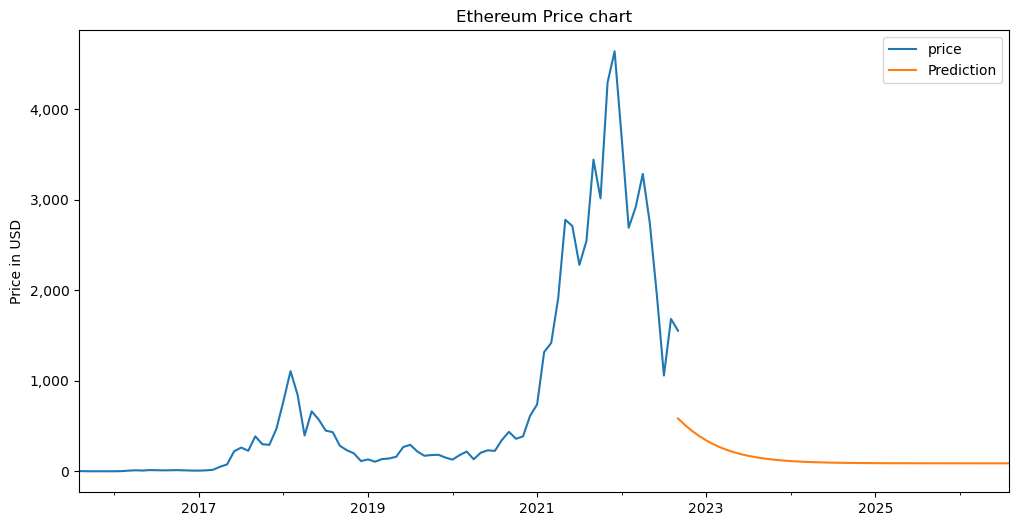

In [225]:
# Plot predictions against known values
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')
title = 'Ethereum Price chart'
ylabel='Price in USD'
xlabel='' # we don't really need a label here

ax = df2['price'].plot(legend=True,figsize=(12,6),title=title)
predictions['Prediction'].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

In [226]:
# same plot as above but with plotly
result = df2.join(predictions['Prediction'], how='outer')
result[['price','Prediction']].iplot()

In [227]:
# in order not to retrain every time we can save the model
model.save('ETH_rnn_model.h5')

In [228]:
# and in order to reload 
from keras.models import load_model
model = load_model('ETH_rnn_model.h5')
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1100)              4848800   
                                                                 
 dense_6 (Dense)             (None, 1)                 1101      
                                                                 
Total params: 4,849,901
Trainable params: 4,849,901
Non-trainable params: 0
_________________________________________________________________
